<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/ejemplos/nn_for_dynamical_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')

# Redes neuronales para sistemas dinámicos.

En este *notebook* demostraremos la utilidad de las redes neuronales para aplicacaciones en sistemas dinámicos. 

## Contexto.

Un sistema dinámico es una forma de describir el pasaje de todos los puntos de un espacio dado $\mathcal S$ através del tiempo. Desde el punto de vista de la mécanica clásica $\mathcal S$ puede representar el conjunto de todas las posibles posiciones y velocidades de un sistema que describe el movimiento de algún cuerpo rígido.

En este caso consideraremos que $\mathcal{S} = \mathbb{R}^{n}$ es un espacio euclidiano. Para cada $\mathbf x \in \mathbb{R}^{n}$ se pude describir su propia evolución por medio del sistema a lo que se le conoce como *trayectoria*. Considerando lo anterior, se pude decir que $\mathbf x = \mathbf{x}(t)$ como función del tiempo, la expresión anterior nos indica el estado al tiempo $t$. Si el tiempo $t \in \mathbb{R}$ se considera al sistema como continuo. 

Para la tarea que queremos realizar en este *notebook* utilizaremos los sistemas dinámicos dados por sistemas diferenciales ordinarios. Sea $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ la función que define un campo vectorial sobre $\mathbb{R}^{n}$, 

$$\dot{\mathbf x}= f(t, \mathbf{x_{t}}; \mathbf{\beta}), $$

donde $\mathbf \beta$ representa un conjunto de parámetros. 

Se pude describir al sistema de forma más explicita, consideremos $\mathbf x_t = [x_1, x_2, \cdots, x_n]^{\top}$,

\begin{align*}
\dot x_{1}&= f_1(t, x_1, x_2, \cdots, x_{n}) \\
\dot x_{2}&= f_2(t, x_1, x_2, \cdots, x_{n})\\
\vdots \\
\dot x_{n}&= f_n(t, x_1, x_2, \cdots, x_{n})
\end{align*}

El problema principal es determinar una solución del sistema que satisfaga una condición inicial $\mathbf x(0) = \mathbf x_{0}$. Es decir, se busca encontrar toda la trayectoria que evoluciona en $f$ empezando en un estado inicial $\mathbf{x}_0$. Sin embargo, cuando se trabaja con ecuaciones diferenciales no lineales, es decir, cuando $f$ es no lineal, no se puede encontrar soluciones bajo ciertas condiciones o es díficil caracterizar una solución.

### Soluciones numéricas.

Afortunadamente existen métodos numéricos que permiten obtener una buena aproximación de la solución real de un sistema de ecuaciones diferenciales, entre ellos están el método de Euler, la familia de métodos Runge-Kutta, entre otros. En nuestro problema utilizaremos el solucionador `scipy.integrate.odeint` que utiliza *lsoda* de la biblioteca odepack de *FORTRAN*.


In [ ]:
from scipy.integrate import odeint

Para usar la función `odeint` es necesario definir el sistema de la siguiente forma: 

```dy/dt = func(t, y, beta)```, 

donde:
* `func` es una función de python que descrbe el lado derecho del sistema. 
* `t` es un arreglo discreto que representa todos los elemntos de un intervalo de tiempo continuo.
* `y` es el estado inicial del sistema.

La forma de utilizar la funcion es la siguiente:

```Y= odeint(func, t, y, args=beta)```

donde `Y` representa la trayectoria asociada a cada elemnto del arreglo del tiempo `t`.

### Importancia de la predicción de esatdos futuros

En general se usa sistemas dinámicos para modelar fenómenos en diversos contextos reales. Una de los retos más facinetes es la predicción de estados futuros. Esta labor pude no parecer interesante en el contexto en que se tiene conocimiento del modelo que evoluciona los estados, pero en los casos de la meteorología y climatología donde no hay un modelo fijo, resulta complicado obtener predicciones a largo plazo. 

Por lo anterior ha sido objeto de estudio el desarrolar métodos que permitan crear predictores confiables. Un enfoque intersante es el de *Data-driven Dynamical Systems* que tiene una colección de métodos basados en Machine Learning que atacan estos problemas.

## Predicción del sistema de Lorenz usando redes neuronales.

El siguiente problema fue tomado del libro [*Data-Driven Science and Engieneering: Machine Learning, Dynamical Systems and Control*](http://databookuw.com) de Steven L. Brunton y J. Nathan Kuttz en el capítulo [capítulo 6](http://databookuw.com/page/page-9/), sección 6.6. Puedes encontrar el código original en matlab en el [repositorio de github](https://github.com/dynamicslab/databook_matlab/blob/master/CH06/CH06_SEC06_1_NNLorenz.m).

Aunque esta tarea es una simple regresión no lineal, funciona como motivación expander los alcances de las redes neuronales

### Planteamiento.

Consideremos el sistema ecuaciones diferenciales no lineales autónomo, es decir que no depende del tiempo, conocido como sistema de Lorenz:
$$
\begin{cases}
\dot x &= \sigma(y -x) \\
\dot y &= x(\rho -z)-y \\
\dot z &= xy -\beta z
\end{cases}
$$

En este caso el estado del sistema esta dado por $\mathbf x = [x, y, z]^{\top}$ y $\mathbf{\beta} = [\sigma, \rho, \beta]^{\top}.$

Este sistema esta entre los más simples y mejor estudiados del área que exhiben caos, que es una caracterización de la sensibilidad con respecto a la condición inicial que pueden tener los sistemas. En estos sistemas caóticos, dos trayectorias con condiciones iniciales cercanas rápidamente divergeran en comportamiento, después de poco tiempo.

Declaramos el sistema en `Python` de la siguiente manera:

In [ ]:
sigma = 10
rho = 28
beta = 8/3

def lorenz(v, t):
  x, y, z = v
  x_d = sigma * (y -x)
  y_d = x * (rho -z) -y
  z_d = x * y - beta * z
  return x_d, y_d, z_d

### Objetivo. 
Crear un predictor de estados del sistema de Lorenz usando redes neuronales. Durante el entrenamiento de la red se ocuparan muestras obtenidas de la simulación del sistema usando distintas condiciones iniciales. Las simulaciones serán las trayectorias del sistema dadas por la función ``odeint``.

### Simulación y datos de entreanamiento

In [ ]:
dt = 0.01 # salto de tiempo
T = 8 # tiempo máxima
n_trayes = 100 # numéro de trayectorias 
n_states = 3 # número de estados del sistema

Haremos varias simulaciones para obtener una gran cantidad de datos que seran útiles para entrenar nuestra red neuronal. Consideremos la $i-$ésima trayectoria $Z^{(i)}$ resultante de simular el sistema usando la condición inicial $\mathbf x_{0}^{(i)}$, 

$$Z^{(i)} = \left\{\mathbf{x}_{1}^{(i)}, \mathbf{x}_{2}^{(i)}, \cdots \mathbf{x}_{t-1}^{(i)}, \mathbf{x}_{t}^{(i)}, \cdots \mathbf{x}_{T}^{(i)}\right\}.$$

Para entrenar la red neuronal necesitamos tener estados que alimentaran a la red para predecir $\left(X^{(i)}\right)$ y las predicciones $\left(Y^{(i)}\right)$, estas colecciones de estados las definimos de la siguiente forma: 
\begin{align*}
X^{(i)} &= \left\{\mathbf{x}_{1}^{(i)}, \mathbf{x}_{2}^{(i)}, \cdots \mathbf{x}_{t-1}^{(i)}, \mathbf{x}_{t}^{(i)}, \cdots \mathbf{x}_{T-1}^{(i)}\right\} \\
Y^{(i)} &= \left\{\mathbf{x}_{2}^{(i)}, \mathbf{x}_{3}^{(i)}, \cdots \mathbf{x}_{t}^{(i)}, \mathbf{x}_{t+1}^{(i)}, \cdots \mathbf{x}_{T}^{(i)}\right\}
\end{align*}

La meta es encontrar un mapeo aproximado de la evolución de $\mathbf{x}_{t}^{(i)}$ en $\mathbf{x}_{t+1}^{(i)}$, es decir, la red debe imitar al mapeo dado por `odeint`, 

$$\mathbf x_{t+1}^{(i)} = f_{odeint}\left(\mathbf x_{t}^{(i)}\right)$$

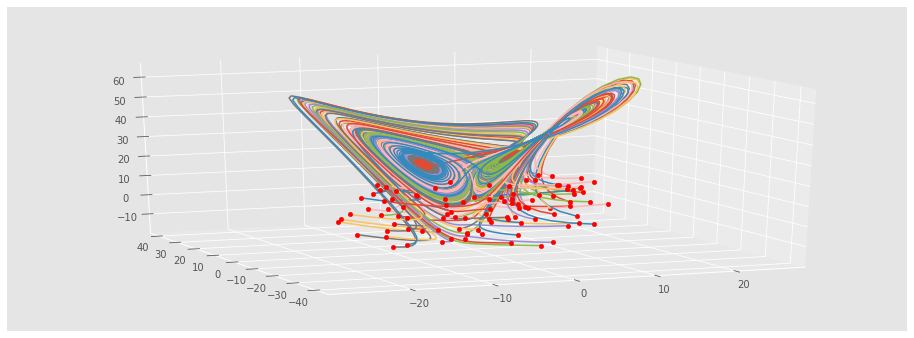

In [ ]:
inputs = np.array([[0, 0, 0]]) # X 
outputs = np.array([[0, 0, 0]]) # Y
t = np.arange(0, T, dt)
fig = plt.figure()
ax = Axes3D(fig) #fig.add_subplot(111, projection='3d')
for _ in range(n_trayes):
  x0 = 30 * (np.random.random(3) -0.5)
  x = odeint(lorenz, x0, t)
  inputs = np.vstack([inputs, x[0:-1, :]])
  outputs = np.vstack([outputs, x[1:-2, :]])
  ax.plot(x[:, 0], x[:, 1], x[:, 2])
  ax.scatter(x0[0], x0[1], x0[2], c='red')

fig.set_size_inches(12.5, 4.5)
ax.view_init(18, -113)
plt.show()

In [ ]:
inputs = inputs[1:-2, :]
outputs = outputs[1:-2, :]

#### Generación del *Dataset* y *Dataloader*

El conjunto de datos esta dado por
$$\mathcal{D} = \left\{x, y \in \bigcup_{i=1}^{100} X^{(i)} \times Y^{(i)}  \right\}$$ 

En este caso no será necesario ocupar la clase abstacta `Dataset` pues las trayectorias son arreglos de `numpy` y basta con transformalos a tensores de `torch` y ocupar la clase `TensorDataset` que es un objeto que hereda de `Dataset` y esta optimizado para tensores.

In [ ]:
import torch.utils.data as data_utils

features = torch.from_numpy(inputs).to(torch.float32) 
targets = torch.from_numpy(inputs).to(torch.float32)
features = features.to(device)  # En caso de tener disponible 'gpu device=cuda'
targets = features.to(device)

dataset = data_utils.TensorDataset(features, targets)

En este caso no usaremos la clase `Subdataset` para separar los datos en dos, utilizaremos el método de `random_split` del módulo `torch.utils.data`, que separa los datos de forma aleatoria de acuerdo a la cantidad de datos en que se quiera dividir.

Observemos que `train_size + val_size = len(dataset)`.

In [ ]:
train_ratio = 0.8
batch_size = 32

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Definición de la red neuronal

En este caso consideraremos una red neuronal unidireccional $f_a(\cdot |\theta): \mathbb{R}^{k \times 3} \rightarrow \mathbb{R}^{k \times 3}$ con la siguiente arquitectura: $a = \langle [3, 16, 16, 3], \{\text{LogSigmoid}, \text{RadBasExp, Linear}\} \rangle$, donde $k$ es el tamaño del mini-batch.

Todas las funciones de activación puden ser encontradas en `torch.nn` salvo `RadBasExp` por lo que la definimos de la siguiente manera:

In [ ]:
import torch.nn as nn 
from torch import Tensor

class RadBasExp(nn.Module):
  """Applies the element-wise function:

    .. math:: https://en.wikipedia.org/wiki/Radial_basis_function 
        \text{RadBasExp}(x) = \exp(- x^2)
    
    Shape:
        - Input: :math:`(N, *)` where `*` means, any number of additional
          dimensions
        - Output: :math:`(N, *)`, same shape as the input
    """
  def forward(self, input: Tensor) -> Tensor:
      return torch.exp(-1*input.pow(2))

Podemos utilizarla de la siguiente form:


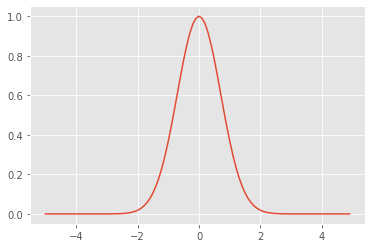

In [ ]:
x = torch.arange(-5., 5., 0.1)
m = RadBasExp()
y = m(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

Observemos que `RadBasExp` al heredar de la clase `nn.Module` podemos incoporar esta función de activación a la red aun cuando la declaramos usando `nn.Sequential`.

In [ ]:
from collections import OrderedDict

# define model architecture
model = nn.Sequential(OrderedDict([
    ('z1', nn.Linear(n_states, 8)),
    ('h1', nn.LogSigmoid()),
    ('z2', nn.Linear(8, 8)),
    ('h2', RadBasExp()),
    ('z3', nn.Linear(8, n_states)),
]))

In [ ]:
model = model.to(device)

La red deberá ser capaz de la siguiente tarea:
$$\hat{\mathbf{x}}_{t+1} =f_a(\mathbf{x}_t |\theta),\quad \|\mathbf{x}_{t+1} - \hat{\mathbf{x}}_{t+1}\| < \epsilon << 1$$ 

### Función objetivo y optimizador

Al ser una tarea de regresión usaremos la función *MSE* (error cuadrático medio) para comparar las predicciones de la red con los valores resultantes de `odeint`. 

In [ ]:
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #, weight_decay=0.0005)

### Entrenamiento

Como en anteriores ocasiones usaremos la función `fit` para cada paso del aprendizaje

In [ ]:
def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss))
    pbar.update(Y.shape[0])
  return avg_loss

In [ ]:
import time

EPOCHS = 1000
train_time = 0

epoch_loss = []
val_loss = []

y ocuparemos un ciclo para juntar todos los paso de entreaniento

In [ ]:
from tqdm import tqdm

model.train()
for epoch in range(EPOCHS):
  start_time = time.time()
  with tqdm(total=train_size, position=0) as pbar_train:
    pbar_train.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - train')
    pbar_train.set_postfix(avg_loss='0.0')
    loss_train = fit(model, train_loader, optimizer, criterion, pbar_train)
    train_time +=  time.time() - start_time
  with tqdm(total=len(val_dataset), position=0) as pbar_val:
    pbar_val.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - val')
    pbar_val.set_postfix(avg_loss='0.0')
    loss_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

  epoch_loss.append(loss_train)
  val_loss.append(loss_val)

print("\n --- %s seconds ---", train_time)

Epoch 1/1000 - train: 100%|██████████| 63918/63918 [00:17<00:00, 3721.65it/s, avg_loss=178.1217]
Epoch 1/1000 - val: : 63918it [00:10, 6331.38it/s, avg_loss=103.4406]
Epoch 2/1000 - train: 100%|██████████| 63918/63918 [00:15<00:00, 4195.44it/s, avg_loss=56.9414]
Epoch 2/1000 - val: : 63918it [00:11, 5781.04it/s, avg_loss=29.9230]
Epoch 3/1000 - train: 100%|██████████| 63918/63918 [00:15<00:00, 3999.76it/s, avg_loss=19.0469]
Epoch 3/1000 - val: : 63918it [00:10, 6218.16it/s, avg_loss=11.9033]
Epoch 4/1000 - train: 100%|██████████| 63918/63918 [00:15<00:00, 4238.30it/s, avg_loss=8.8568]
Epoch 4/1000 - val: : 63918it [00:10, 6199.81it/s, avg_loss=6.7835]
Epoch 5/1000 - train: 100%|██████████| 63918/63918 [00:14<00:00, 4261.73it/s, avg_loss=5.7446]
Epoch 5/1000 - val: : 63918it [00:10, 6221.23it/s, avg_loss=4.9237]
Epoch 6/1000 - train: 100%|██████████| 63918/63918 [00:15<00:00, 4227.34it/s, avg_loss=4.4261]
Epoch 6/1000 - val: : 63918it [00:10, 6171.07it/s, avg_loss=3.9254]
Epoch 7/1000 -

### Evaluación del entreanamiento

In [ ]:
# Best validation performace and epoch
best_val, epoch = min((v, e) for (e, v) in enumerate(val_loss))

In [ ]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.axhline(y=best_val, linestyle='--')
plt.title('Best Validation Performace is {:.4f}'.format(best_val)+ ' at epoch {}'.format(epoch))
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'best per'], loc='upper left')
plt.show()

### Guardar y cargar red neuronal
Para guardar:

In [ ]:
PATH ='/content/my_net'
torch.save(model.state_dict(), PATH)

Para cargar: 


In [ ]:
#model.load_state_dict(torch.load(PATH))

### Prueba del modelo

In [ ]:
def net_vs_odeint(net, X_net, X, t, f):
  X_tensor = torch.from_numpy(X_net).unsqueeze(dim=0) # <- 1) de numpy a torch, 2)de dim 1 a dim 2
  Y = odeint(f, X, t)[1, :]
  Y_tensor = net(X_tensor.to(torch.float32).to(device))
  Y_net =  Y_tensor.squeeze(dim=0).detach().cpu().numpy() # <- 1) de dim 2 a dim 1, 2) quita registro de gradiente, 3) convierte a numpy
  return Y_net, Y

In [ ]:
model.eval()
test_trayes = 2 
n_steps = len(t)
fig = plt.figure()
ax = Axes3D(fig)
for _ in range(test_trayes):
  V = np.zeros((n_steps, 3)) 
  V_net = np.zeros((n_steps, 3))
  v0 = 30 * (np.random.random(3) -0.5) # v = (x, y, z)
  v = v0; v_net = v0
  V_net[0, :] = v0; V[0, :] = v0
  for s in range(1, n_steps):
    v_net, v = net_vs_odeint(model, v_net, v, t[0:2], lorenz)
    V_net[s, :] = v_net
    V[s, :] = v

  ax.plot(V[:, 0], V[0:, 1], V[0:, 2], label='odeint', alpha=0.2)
  ax.plot(V_net[:, 0], V_net[:, 1], V_net[:, 2], linestyle='dashed', label='NN')
  ax.scatter(v0[0], v0[1], v0[2], c='red')

ax.legend()
ax.view_init(18, -113)
fig.set_size_inches(12.5, 4.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 1)
axis = ['$x$', '$y$', '$z$']
for i, a in enumerate(axis):
  ax[i].plot(t, V[:, i],label='odeint', alpha=0.3)
  ax[i].plot(t, V_net[:, i], label='NN', linestyle='dashed')
  ax[i].set_ylabel(a)
  ax[i].set_xlabel('$t$')
  ax[i].legend()

fig.set_size_inches(14.5, 6.5)
plt.show()